## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization
def build_mlp(input_shape, output_units=10, num_neurons=[256, 256, 256]):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [7]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.1, 0.3, 0.5]
redice_lr_patient = [3, 5, 8]

In [8]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["acc"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=reduce_patient, 
                              verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

Numbers of exp: 0, reduce_factor: 0.10, reduce_patient: 3
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 256)               65792     
_________________________________________________________________
b

50000/50000 [==============================] - 2s 44us/step - loss: 1.2706 - acc: 0.5573 - val_loss: 1.4787 - val_acc: 0.4782
Epoch 14/25
50000/50000 [==============================] - 2s 42us/step - loss: 1.2488 - acc: 0.5667 - val_loss: 1.4720 - val_acc: 0.4841
Epoch 15/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.2295 - acc: 0.5746 - val_loss: 1.4717 - val_acc: 0.4806
Epoch 16/25
50000/50000 [==============================] - 2s 39us/step - loss: 1.2115 - acc: 0.5793 - val_loss: 1.4683 - val_acc: 0.4855
Epoch 17/25
50000/50000 [==============================] - 2s 39us/step - loss: 1.1912 - acc: 0.5866 - val_loss: 1.4687 - val_acc: 0.4832
Epoch 18/25
50000/50000 [==============================] - 2s 41us/step - loss: 1.1730 - acc: 0.5950 - val_loss: 1.4516 - val_acc: 0.4926
Epoch 19/25
50000/50000 [==============================] - 2s 39us/step - loss: 1.1562 - acc: 0.6002 - val_loss: 1.4586 - val_acc: 0.4840
Epoch 20/25
50000/50000 [=====================

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 3s 55us/step - loss: 2.7310 - acc: 0.1535 - val_loss: 2.2714 - val_acc: 0.1345
Epoch 2/25
50000/50000 [==============================] - 3s 50us/step - loss: 2.2718 - acc: 0.2500 - val_loss: 2.1746 - val_acc: 0.2167
Epoch 3/25
50000/50000 [==============================] - 2s 48us/step - loss: 2.1102 - acc: 0.2892 - val_loss: 2.0788 - val_acc: 0.2618
Epoch 4/25
50000/50000 [==============================] - 2s 46us/step - loss: 2.0185 - acc: 0.3100 - val_loss: 1.9972 - val_acc: 0.2905
Epoch 5/25
50000/50000 [==============================] - 2s 40us/step - loss: 1.9537 - acc: 0.3290 - val_loss: 1.9308 - val_acc: 0.3179
Epoch 6/25
50000/50000 [==============================] - 3s 61us/step - loss: 1.9053 - acc: 0.3432 - val_loss: 1.8871 - val_acc: 0.3323
Epoch 7/25
50000/50000 [==============================] - 2s 46us/step - loss: 1.8652 - acc: 0.3547 - val_loss: 1.8563 - val_acc

50000/50000 [==============================] - 2s 44us/step - loss: 1.5641 - acc: 0.4552 - val_loss: 1.6669 - val_acc: 0.4236
Epoch 25/25
50000/50000 [==============================] - 2s 44us/step - loss: 1.5551 - acc: 0.4575 - val_loss: 1.6611 - val_acc: 0.4245
Numbers of exp: 5, reduce_factor: 0.30, reduce_patient: 8
Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_16 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
b

50000/50000 [==============================] - 2s 43us/step - loss: 1.7325 - acc: 0.3985 - val_loss: 1.7688 - val_acc: 0.3837
Epoch 12/25
50000/50000 [==============================] - 2s 43us/step - loss: 1.7108 - acc: 0.4064 - val_loss: 1.7564 - val_acc: 0.3859
Epoch 13/25
50000/50000 [==============================] - 4s 89us/step - loss: 1.6938 - acc: 0.4111 - val_loss: 1.7466 - val_acc: 0.3931
Epoch 14/25
50000/50000 [==============================] - 4s 80us/step - loss: 1.6766 - acc: 0.4173 - val_loss: 1.7368 - val_acc: 0.3952
Epoch 15/25
50000/50000 [==============================] - 2s 40us/step - loss: 1.6610 - acc: 0.4224 - val_loss: 1.7274 - val_acc: 0.3981
Epoch 16/25
50000/50000 [==============================] - 4s 79us/step - loss: 1.6466 - acc: 0.4273 - val_loss: 1.7184 - val_acc: 0.4004
Epoch 17/25
50000/50000 [==============================] - 2s 42us/step - loss: 1.6345 - acc: 0.4304 - val_loss: 1.7114 - val_acc: 0.4038
Epoch 18/25
50000/50000 [=====================

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 4s 74us/step - loss: 2.7123 - acc: 0.1466 - val_loss: 2.2558 - val_acc: 0.1668
Epoch 2/25
50000/50000 [==============================] - 3s 51us/step - loss: 2.2896 - acc: 0.2420 - val_loss: 2.1932 - val_acc: 0.2146
Epoch 3/25
50000/50000 [==============================] - 4s 79us/step - loss: 2.1193 - acc: 0.2819 - val_loss: 2.1039 - val_acc: 0.2500
Epoch 4/25
50000/50000 [==============================] - 2s 41us/step - loss: 2.0206 - acc: 0.3100 - val_loss: 2.0186 - val_acc: 0.2821
Epoch 5/25
50000/50000 [==============================] - 4s 87us/step - loss: 1.9527 - acc: 0.3290 - val_loss: 1.9366 - val_acc: 0.3167
Epoch 6/25
50000/50000 [==============================] - 4s 70us/step - loss: 1.9016 - acc: 0.3441 - val_loss: 1.8857 - val_acc: 0.3323
Epoch 7/25
50000/50000 [==============================] - 3s 62us/step - loss: 1.8610 - acc: 0.3564 - val_loss: 1.8496 - val_acc


Epoch 00022: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Epoch 23/25
50000/50000 [==============================] - 2s 46us/step - loss: 0.5984 - acc: 0.8140 - val_loss: 1.3415 - val_acc: 0.5508
Epoch 24/25
50000/50000 [==============================] - 5s 93us/step - loss: 0.5985 - acc: 0.8144 - val_loss: 1.3428 - val_acc: 0.5511
Epoch 25/25
50000/50000 [==============================] - 5s 96us/step - loss: 0.5978 - acc: 0.8135 - val_loss: 1.3436 - val_acc: 0.5522

Epoch 00025: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.
Numbers of exp: 10, reduce_factor: 0.10, reduce_patient: 5
Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_______________

Epoch 7/25
50000/50000 [==============================] - 5s 94us/step - loss: 3.0590 - acc: 0.1058 - val_loss: 2.7496 - val_acc: 0.1084
Epoch 8/25
50000/50000 [==============================] - 4s 88us/step - loss: 3.0592 - acc: 0.1061 - val_loss: 2.8140 - val_acc: 0.1050
Epoch 9/25
50000/50000 [==============================] - 2s 43us/step - loss: 3.0593 - acc: 0.1061 - val_loss: 2.8690 - val_acc: 0.1037

Epoch 00009: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-12.
Epoch 10/25
50000/50000 [==============================] - 5s 93us/step - loss: 3.0583 - acc: 0.1051 - val_loss: 2.9147 - val_acc: 0.1033
Epoch 11/25
50000/50000 [==============================] - 5s 95us/step - loss: 3.0590 - acc: 0.1065 - val_loss: 2.9526 - val_acc: 0.1013
Epoch 12/25
50000/50000 [==============================] - 5s 94us/step - loss: 3.0585 - acc: 0.1064 - val_loss: 2.9828 - val_acc: 0.0992
Epoch 13/25
50000/50000 [==============================] - 2s 43us/step - loss: 3.0587 - acc: 

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 4s 81us/step - loss: 3.1655 - acc: 0.0870 - val_loss: 2.3691 - val_acc: 0.0990
Epoch 2/25
50000/50000 [==============================] - 2s 44us/step - loss: 3.1656 - acc: 0.0870 - val_loss: 2.4107 - val_acc: 0.0980
Epoch 3/25
50000/50000 [==============================] - 2s 44us/step - loss: 3.1652 - acc: 0.0870 - val_loss: 2.4864 - val_acc: 0.1027
Epoch 4/25
50000/50000 [==============================] - 5s 93us/step - loss: 3.1667 - acc: 0.0873 - val_loss: 2.5693 - val_acc: 0.1015
Epoch 5/25
50000/50000 [==============================] - 5s 95us/step - loss: 3.1655 - acc: 0.0860 - val_loss: 2.6509 - val_acc: 0.0970
Epoch 6/25
50000/50000 [==============================] - 5s 103us/step - loss: 3.1651 - acc: 0.0869 - val_loss: 2.7301 - val_acc: 0.0920
Epoch 7/25
50000/50000 [==============================] - 3s 59us/step - loss: 3.1650 - acc: 0.0866 - val_loss: 2.8062 - val_ac

50000/50000 [==============================] - 5s 94us/step - loss: 3.3362 - acc: 0.0745 - val_loss: 3.2967 - val_acc: 0.0796
Epoch 25/25
50000/50000 [==============================] - 5s 96us/step - loss: 3.3367 - acc: 0.0741 - val_loss: 3.2970 - val_acc: 0.0796
Numbers of exp: 15, reduce_factor: 0.50, reduce_patient: 3
Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_46 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________

50000/50000 [==============================] - 4s 86us/step - loss: 3.0159 - acc: 0.0971 - val_loss: 2.8887 - val_acc: 0.0998
Epoch 12/25
50000/50000 [==============================] - 4s 86us/step - loss: 3.0156 - acc: 0.0963 - val_loss: 2.9202 - val_acc: 0.0995
Epoch 13/25
50000/50000 [==============================] - 5s 95us/step - loss: 3.0158 - acc: 0.0967 - val_loss: 2.9448 - val_acc: 0.0989
Epoch 14/25
50000/50000 [==============================] - 5s 95us/step - loss: 3.0153 - acc: 0.0971 - val_loss: 2.9636 - val_acc: 0.0986
Epoch 15/25
50000/50000 [==============================] - 5s 95us/step - loss: 3.0148 - acc: 0.0969 - val_loss: 2.9777 - val_acc: 0.0994
Epoch 16/25
50000/50000 [==============================] - 4s 84us/step - loss: 3.0162 - acc: 0.0957 - val_loss: 2.9875 - val_acc: 0.0991
Epoch 17/25
50000/50000 [==============================] - 5s 96us/step - loss: 3.0155 - acc: 0.0966 - val_loss: 2.9941 - val_acc: 0.0988
Epoch 18/25
50000/50000 [=====================

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 4s 76us/step - loss: 1.8483 - acc: 0.3659 - val_loss: 2.4037 - val_acc: 0.1767
Epoch 2/25
50000/50000 [==============================] - 4s 74us/step - loss: 1.5450 - acc: 0.4502 - val_loss: 2.2807 - val_acc: 0.2530
Epoch 3/25
50000/50000 [==============================] - 3s 61us/step - loss: 1.4276 - acc: 0.4950 - val_loss: 1.9727 - val_acc: 0.3168
Epoch 4/25
50000/50000 [==============================] - 3s 61us/step - loss: 1.3461 - acc: 0.5234 - val_loss: 1.8063 - val_acc: 0.3774
Epoch 5/25
50000/50000 [==============================] - 3s 63us/step - loss: 1.2738 - acc: 0.5523 - val_loss: 1.8933 - val_acc: 0.3684
Epoch 6/25
50000/50000 [==============================] - 3s 63us/step - loss: 1.2129 - acc: 0.5697 - val_loss: 1.9625 - val_acc: 0.3574
Epoch 7/25
50000/50000 [==============================] - 3s 61us/step - loss: 1.1641 - acc: 0.5876 - val_loss: 1.7409 - val_acc

Epoch 20/25
50000/50000 [==============================] - 5s 110us/step - loss: 3.0059 - acc: 0.1029 - val_loss: 3.0188 - val_acc: 0.0992
Epoch 21/25
50000/50000 [==============================] - 4s 76us/step - loss: 3.0061 - acc: 0.1031 - val_loss: 3.0197 - val_acc: 0.0994

Epoch 00021: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-11.
Epoch 22/25
50000/50000 [==============================] - 5s 94us/step - loss: 3.0057 - acc: 0.1030 - val_loss: 3.0205 - val_acc: 0.0997
Epoch 23/25
50000/50000 [==============================] - 5s 94us/step - loss: 3.0055 - acc: 0.1028 - val_loss: 3.0211 - val_acc: 0.0995
Epoch 24/25
50000/50000 [==============================] - 5s 95us/step - loss: 3.0070 - acc: 0.1030 - val_loss: 3.0212 - val_acc: 0.0996
Epoch 25/25
50000/50000 [==============================] - 5s 94us/step - loss: 3.0063 - acc: 0.1035 - val_loss: 3.0214 - val_acc: 0.0998
Numbers of exp: 20, reduce_factor: 0.10, reduce_patient: 8
Model: "model_21"
_____________

Epoch 6/25
50000/50000 [==============================] - 5s 93us/step - loss: 3.0688 - acc: 0.0938 - val_loss: 2.6529 - val_acc: 0.0998
Epoch 7/25
50000/50000 [==============================] - 5s 94us/step - loss: 3.0676 - acc: 0.0945 - val_loss: 2.7302 - val_acc: 0.0961
Epoch 8/25
50000/50000 [==============================] - 5s 93us/step - loss: 3.0689 - acc: 0.0944 - val_loss: 2.7982 - val_acc: 0.0971
Epoch 9/25
50000/50000 [==============================] - 4s 82us/step - loss: 3.0688 - acc: 0.0945 - val_loss: 2.8551 - val_acc: 0.0961
Epoch 10/25
50000/50000 [==============================] - 2s 43us/step - loss: 3.0680 - acc: 0.0945 - val_loss: 2.9018 - val_acc: 0.0978
Epoch 11/25
50000/50000 [==============================] - 5s 90us/step - loss: 3.0675 - acc: 0.0942 - val_loss: 2.9390 - val_acc: 0.0977
Epoch 12/25
50000/50000 [==============================] - 5s 93us/step - loss: 3.0678 - acc: 0.0942 - val_loss: 2.9687 - val_acc: 0.0971
Epoch 13/25
50000/50000 [=============

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 4s 78us/step - loss: 3.1932 - acc: 0.0767 - val_loss: 2.3476 - val_acc: 0.0933
Epoch 2/25
50000/50000 [==============================] - 5s 97us/step - loss: 3.1930 - acc: 0.0776 - val_loss: 2.4205 - val_acc: 0.0911
Epoch 3/25
50000/50000 [==============================] - 2s 46us/step - loss: 3.1936 - acc: 0.0772 - val_loss: 2.5049 - val_acc: 0.0829
Epoch 4/25
50000/50000 [==============================] - 5s 91us/step - loss: 3.1932 - acc: 0.0769 - val_loss: 2.5858 - val_acc: 0.0796
Epoch 5/25
50000/50000 [==============================] - 5s 93us/step - loss: 3.1926 - acc: 0.0785 - val_loss: 2.6660 - val_acc: 0.0774
Epoch 6/25
50000/50000 [==============================] - 5s 93us/step - loss: 3.1935 - acc: 0.0769 - val_loss: 2.7450 - val_acc: 0.0757
Epoch 7/25
50000/50000 [==============================] - 5s 93us/step - loss: 3.1932 - acc: 0.0768 - val_loss: 2.8206 - val_acc

50000/50000 [==============================] - 5s 93us/step - loss: 2.9999 - acc: 0.1047 - val_loss: 3.0000 - val_acc: 0.1047
Epoch 25/25
50000/50000 [==============================] - 5s 94us/step - loss: 3.0021 - acc: 0.1045 - val_loss: 3.0002 - val_acc: 0.1045
Numbers of exp: 25, reduce_factor: 0.50, reduce_patient: 5
Model: "model_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_76 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________

50000/50000 [==============================] - 2s 43us/step - loss: 3.0940 - acc: 0.0893 - val_loss: 2.9573 - val_acc: 0.0906
Epoch 12/25
50000/50000 [==============================] - 4s 88us/step - loss: 3.0932 - acc: 0.0894 - val_loss: 2.9975 - val_acc: 0.0902
Epoch 13/25
50000/50000 [==============================] - 3s 57us/step - loss: 3.0934 - acc: 0.0894 - val_loss: 3.0294 - val_acc: 0.0901
Epoch 14/25
50000/50000 [==============================] - 3s 59us/step - loss: 3.0947 - acc: 0.0891 - val_loss: 3.0536 - val_acc: 0.0894
Epoch 15/25
50000/50000 [==============================] - 3s 57us/step - loss: 3.0944 - acc: 0.0895 - val_loss: 3.0714 - val_acc: 0.0893
Epoch 16/25
50000/50000 [==============================] - 3s 56us/step - loss: 3.0935 - acc: 0.0887 - val_loss: 3.0836 - val_acc: 0.0891
Epoch 17/25
50000/50000 [==============================] - 5s 90us/step - loss: 3.0933 - acc: 0.0895 - val_loss: 3.0916 - val_acc: 0.0890
Epoch 18/25
50000/50000 [=====================

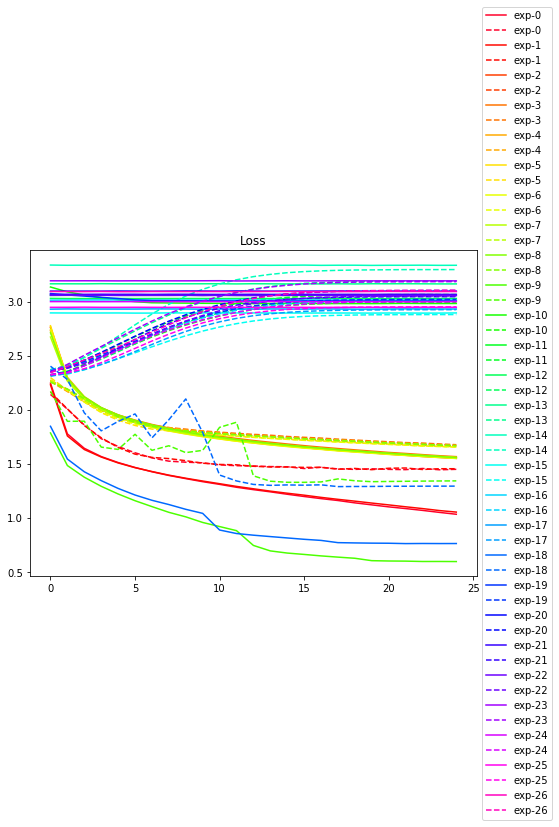

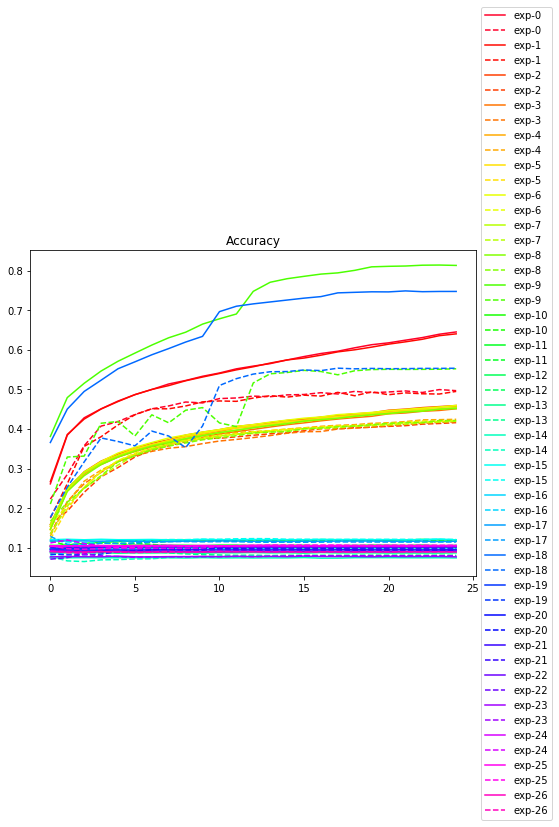

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()